In [1]:
import networkx as nx
import random
import numpy as np

In [2]:
n = 9

In [3]:
G = nx.complete_graph(n, nx.DiGraph())
for (u,v) in G.edges:
    G.edges[u,v]['weight'] = random.random()

### Approximating PathMaxATSP via matching

In [4]:
Gu = nx.complete_graph(n)
for (u,v) in Gu.edges:
    w1 = G.edges[u,v]['weight']
    w2 = G.edges[v,u]['weight']
    Gu.edges[u,v]['weight'] = max(w1, w2)

In [5]:
matchings = nx.max_weight_matching(Gu)
print(matchings)

{(0, 1), (8, 4), (3, 5), (2, 7)}


In [6]:
dir_matchings = []
for (u,v) in matchings:
    if G.edges[u,v]['weight'] > G.edges[v,u]['weight']:
        dir_matchings.append((u,v))
    else:
        dir_matchings.append((v,u))
print(dir_matchings)

[(0, 1), (8, 4), (5, 3), (7, 2)]


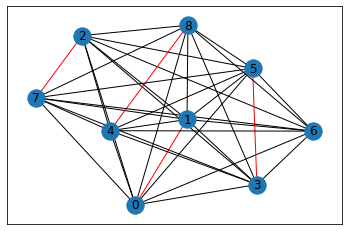

In [7]:
colors = []
for (u,v) in Gu.edges:
    if (u,v) in dir_matchings or (v,u) in dir_matchings:
        colors.append("red")
    else:
        colors.append("black")

nx.draw_networkx(Gu, edge_color=colors)

In [8]:
path = []
for (u,v) in dir_matchings:
    path.append(u)
    path.append(v)
print(path)

[0, 1, 8, 4, 5, 3, 7, 2]


In [9]:
if n % 2 == 1:
    vertex_sum = n * (n-1) / 2
    final_v = int(vertex_sum - sum(path))
    path.append(final_v)
    print(path)

[0, 1, 8, 4, 5, 3, 7, 2, 6]


In [10]:
def get_path_weight(path):
    total_weight = 0
    for u,v in zip(path, path[1:]):
        total_weight += G.edges[u,v]['weight']
    return total_weight

In [11]:
print(get_path_weight(path))

5.56064224597014


In [17]:
def draw_path(path):
    edges = list(zip(path, path[1:]))
    colors = []
    for (u,v) in Gu.edges:
        if (u,v) in edges or (v,u) in edges:
            colors.append("red")
        else:
            colors.append("black")

    nx.draw_networkx(Gu, edge_color=colors)

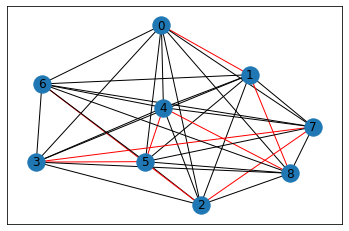

In [19]:
draw_path(path)